In [106]:
import os
import pandas as pd
import numpy as np
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress

To Do
- Write up the first part of my findings. Clean up my existing code. See if I can get it to pass the Udacity tutors
- After that, work on the corruption index

To Do
- Throw all the data check functions into a .py file once I've got the code. 
-- Also, there might be libraries that do this kind of thing. If not, I'll definitely want to save this code so that I can use it in the future
- It might also make sense to break up the analyses into different ipynb file so that they are easier to read


In [107]:
#Iterate over the data in the folder and store the cleaned data as a dataframe in the 'dataframes' dictionary.

# Folder path
folder_path = './border_data'

# Initialize a dictionary to hold the DataFrames
dataframes = {}

# List all files in the folder
files = os.listdir(folder_path)

# Regular expression to match the file names and extract the year
pattern = r'texas_border_report_(\d{4}).xlsx'

for file_name in files:
    match = re.match(pattern, file_name)
    if match:
        year = match.group(1)
        file_path = os.path.join(folder_path, file_name)
        
        print(f"Loading file: {file_name}")
        
        # Load the Excel file into a DataFrame
        df = pd.read_excel(
            file_path, 
            sheet_name='By Agency', 
            skiprows=1, 
            skipfooter=6,
            dtype={'NIBRS Start Date': 'object'}
        )
        
        #Date is formated as MMM-YY in excel, but the underlying data has the day. Going to stick with the MMM-YY formating for now
        df['NIBRS Start Date'] = pd.to_datetime(df['NIBRS Start Date'], format='%b-%y')
        df['Population'] = df['Population'].str.replace(',', '').astype(int)
        df.drop(columns=['Total'], inplace=True)
        
        superscript_removal_map = str.maketrans('', '', '¹²³⁴⁵⁶⁷⁸⁹⁰')
        df.columns = [col.lower().replace('  ', '_').replace(' ', '_').replace(',','').translate(superscript_removal_map) for col in df.columns]

        # Store the DataFrame in the dictionary with a dynamic key
        dataframes[f'report_{year}'] = df


Loading file: texas_border_report_2017.xlsx
Loading file: texas_border_report_2018.xlsx
Loading file: texas_border_report_2019.xlsx
Loading file: texas_border_report_2020.xlsx
Loading file: texas_border_report_2021.xlsx
Loading file: texas_border_report_2022.xlsx
Loading file: texas_border_report_2023.xlsx


In [108]:
#Specific a reference dataframe in order to check the data
def extract_reference(key, dataframes):
    # Check if the key exists in the dictionary
    if key in dataframes:
        # Extract the dataframe associated with the key and remove the key from the dictionary
        reference_df = dataframes.pop(key)
        # Return both the extracted dataframe and the modified dictionary
        return reference_df, dataframes
    else:
        # Handle the case where the key does not exist
        raise KeyError(f"Key '{key}' not found in the dictionary.")


#I'm using the most recent, complete report in as my reference
current_report, old_reports = extract_reference('report_2023', dataframes)

In [109]:
#Check the shapes of the dataframes
def check_shape(reference_df, dataframes_dict):
    # Initialize a list to hold mismatch information
    mismatches = []

    # Iterate over the dictionary items
    for key, df in dataframes_dict.items():
        # Check if the current dataframe's shape matches the reference dataframe's shape
        if df.shape != reference_df.shape:
            # Add the mismatch information to the list
            mismatches.append((key, df.shape))

    # Check if there were any mismatches
    if mismatches:
        # Report all mismatches
        for key, shape in mismatches:
            print(f"{key} shape does not match the reference dataframe.")
            print(f"Reference shape: {reference_df.shape}, {key} shape: {shape}")
    else:
        # If no mismatches were found, print the following message
        print("All dataframes have the same shape.")

check_shape(current_report, old_reports)

All dataframes have the same shape.


In [110]:
#Function to check if all of the columns in the reference dataframe are present in the other dataframes
def check_columns(column_names, dataframes_dict):
    missing_columns = {}  # Dictionary to track dataframes missing any of the specified columns

    for key, df in dataframes_dict.items():
        # Check if all specified columns are present in the dataframe
        missing = [column for column in column_names if column not in df.columns]
        if missing:
            missing_columns[key] = missing

    if not missing_columns:
        print("The columns in the old reports are the same as the column in")
    else:
        for key, columns in missing_columns.items():
            print(f"Dataframe '{key}' is missing the following columns: {columns}")

#Generate list of columns in the current report
current_report_columns = list(current_report.columns)

#Check the columns
check_columns(current_report_columns, old_reports)

The columns in the old reports are the same as the column in


In [111]:
def check_column_values(column_name, reference_df, dataframes_dict):
    # Get the set of unique values from the reference dataframe, treating NaN as a distinct value
    reference_values = set(reference_df[column_name].dropna().unique())
    reference_values.add(np.nan) if reference_df[column_name].isnull().any() else reference_values
    
    # Initialize a dictionary to store comparison results
    results = {'reference': sorted(reference_values)}
    
    for key, df in dataframes_dict.items():
        # Ensure the column exists in the dataframe
        if column_name not in df.columns:
            print(f"{key} dataframe does not have the column '{column_name}'.")
            continue
        
        # Check data type consistency
        if df[column_name].dtype != reference_df[column_name].dtype:
            print(f"Data type mismatch in '{key}' for column '{column_name}': "
                  f"{df[column_name].dtype} vs {reference_df[column_name].dtype}")
            continue
        
        # Get the set of unique values from the current dataframe, treating NaN distinctly
        df_values = set(df[column_name].dropna().unique())
        df_values.add(np.nan) if df[column_name].isnull().any() else df_values
        
        # Compare the sets of values
        missing_values = reference_values - df_values
        if missing_values:
            results[key] = sorted(df_values)
            print(f"'{key}' dataframe is missing the following values: {sorted(missing_values)}")
        else:
            print(f"Values in the reference dataframe match the values in the '{key}' dataframe.")
    
    # Create a summary dataframe
    summary_df = pd.DataFrame(dict([(k, pd.Series(list(v))) for k, v in results.items()]))
    return summary_df

In [112]:
summary_df = check_column_values('agency_name', current_report, old_reports)

Values in the reference dataframe match the values in the 'report_2017' dataframe.
Values in the reference dataframe match the values in the 'report_2018' dataframe.
Values in the reference dataframe match the values in the 'report_2019' dataframe.
Values in the reference dataframe match the values in the 'report_2020' dataframe.
Values in the reference dataframe match the values in the 'report_2021' dataframe.
Values in the reference dataframe match the values in the 'report_2022' dataframe.


In [113]:
#Create a dataframe with all of the data from the reports

#Adding the current report dataframe back into the dictionary
dataframes['report_2023'] = current_report

#Extract and combine the dataframes 
for key, df in dataframes.items():
    year = int(key.split('_')[1])  # Extract the year from the key
    date_str = f'12/31/{year}' # Create a string representing '12/31/YYYY' for each row
    
    # Convert the string to datetime and assign to the new column 'report_year'
    df['report_year'] = pd.to_datetime(date_str, format='%m/%d/%Y')
    
    globals()[key] = df  # Update the global variable with the modified DataFrame


# Combine all DataFrames into a single DataFrame
border_report = pd.concat(dataframes.values(), ignore_index=True)

#Check to make sure all of the years are in the report
border_report['report_year'].unique()

<DatetimeArray>
['2017-12-31 00:00:00', '2018-12-31 00:00:00', '2019-12-31 00:00:00',
 '2020-12-31 00:00:00', '2021-12-31 00:00:00', '2022-12-31 00:00:00',
 '2023-12-31 00:00:00']
Length: 7, dtype: datetime64[ns]

In [114]:
#Create column to identify the different agency types within the report
border_report['agency_type'] = ''

# Define conditions for different agency types
police_condition = border_report['agency_name'].str.contains('PD', case=False)
sheriff_condition = border_report['agency_name'].str.contains('SO', case=False)
constable_condition = border_report['agency_name'].str.contains('CONSTABLE', case=False)

# Assign the agency type based on conditions
border_report.loc[police_condition, 'agency_type'] = 'Police Department'
border_report.loc[sheriff_condition, 'agency_type'] = "Sheriff's Office"
border_report.loc[constable_condition, 'agency_type'] = 'Constable'

#Create column to label the univerity police departments
border_report['university_pd'] = border_report['agency_name'].str.contains('UNIV|COLLEGE', case=False, na=False)

# Display the DataFrame with the new 'agency_type' column
border_report[['agency_name', 'agency_type', 'university_pd']].head()


,agency_name,agency_type,university_pd
0,ALAMO PD,Police Department,False
1,ALPINE PD,Police Department,False
2,ALTON PD,Police Department,False
3,ANTHONY PD,Police Department,False
4,BREWSTER CO SO,Sheriff's Office,False


In [115]:
#Create 'nibrs_status' column by comparing 'nibrs_start_date' to 'report_year'
def determine_nibrs_status(row):
    report_year = row['report_year'].year  # Extract the year from report_year
    nibrs_start_year = row['nibrs_start_date'].year  # Extract the year from nibrs_start_date

    # Determine NIBRS status based on comparison of start year and report year
    if nibrs_start_year < report_year:
        return 'active'
    elif nibrs_start_year == report_year:
        return 'started'
    else:
        return 'inactive'

#Add the column to the report
border_report['nibrs_status'] = border_report.apply(determine_nibrs_status, axis=1)

#Check the nibrs_status logic
border_report[['agency_name', 'report_year', 'nibrs_start_date', 'nibrs_status']].head()

,agency_name,report_year,nibrs_start_date,nibrs_status
0,ALAMO PD,2017-12-31,2018-08-01,inactive
1,ALPINE PD,2017-12-31,2020-04-01,inactive
2,ALTON PD,2017-12-31,2019-09-01,inactive
3,ANTHONY PD,2017-12-31,2020-12-01,inactive
4,BREWSTER CO SO,2017-12-31,2015-01-01,active


In [116]:
#Calculate how many months each agency should have reported data
def nibrs_eligible_months(row):
    # Directly use 'nibrs_start_date' as it's already a datetime object
    nibrs_start_date = row['nibrs_start_date']
    
    # Extract the year directly from 'report_year' (assuming it's already a datetime object)
    report_year = row['report_year'].year

    # Calculate the number of eligible months based on conditions
    if nibrs_start_date.year < report_year:
        return 12
    elif nibrs_start_date.year == report_year:
        return (12 - nibrs_start_date.month + 1)  # +1 to include the start month itself
    else:
        return 0

#Add nibrs_eligible_months column    
border_report['nibrs_eligible_months'] = border_report.apply(nibrs_eligible_months, axis=1)

#Add NIBRS preliminary reporting flag
border_report['has_preliminary_nibrs_reporting'] = border_report['nibrs_eligible_months'] < border_report['months_reported']


#Check nibrs_eligible_months logic
border_report[
        ['agency_name', 
        'report_year', 
        'nibrs_start_date', 
        'nibrs_status', 
        'nibrs_eligible_months', 
        'months_reported',
        'has_preliminary_nibrs_reporting']
    ].sort_values('months_reported', ascending=False).head()

,agency_name,report_year,nibrs_start_date,nibrs_status,nibrs_eligible_months,months_reported,has_preliminary_nibrs_reporting
594,ZAPATA CO SO,2023-12-31,2020-01-01,active,12,12,False
210,LOS FRESNOS PD,2019-12-31,2017-10-01,active,12,12,False
445,EL PASO ISD PD,2022-12-31,2021-01-01,active,12,12,False
193,HARLINGEN PD,2019-12-31,2018-01-01,active,12,12,False
443,EL PASO CO SO,2022-12-31,2019-10-01,active,12,12,False


In [117]:
# Define the function to calculate the NIBRS contribution percentage
def calculate_nibrs_contribution_percentage(row):
    #Normalizing the cases where agencies are reporting data earlier
    if row['nibrs_eligible_months'] < row['months_reported']:
        return 100
    elif row['nibrs_eligible_months'] > 0:
        return round((row['months_reported'] / row['nibrs_eligible_months']) * 100, 2)
    else:
        return 0


# Apply the function to create the new column with rounded values
border_report['nibrs_contribution_percentage'] = border_report.apply(calculate_nibrs_contribution_percentage, axis=1)

#Check logic
border_report[['agency_name', 
                     'report_year', 
                     'nibrs_start_date', 
                     'nibrs_status', 
                     'nibrs_eligible_months', 
                     'nibrs_contribution_percentage',
                     'months_reported',
                     'has_preliminary_nibrs_reporting'
                     ]].sort_values('nibrs_contribution_percentage', ascending=False).head()


,agency_name,report_year,nibrs_start_date,nibrs_status,nibrs_eligible_months,nibrs_contribution_percentage,months_reported,has_preliminary_nibrs_reporting
594,ZAPATA CO SO,2023-12-31,2020-01-01,active,12,100.0,12,False
428,ANTHONY PD,2022-12-31,2020-12-01,active,12,100.0,12,False
425,ALAMO PD,2022-12-31,2018-08-01,active,12,100.0,12,False
221,PHARR PD,2019-12-31,2021-01-01,inactive,0,100.0,2,True
220,PENITAS PD,2019-12-31,2019-01-01,started,12,100.0,12,False


In [118]:
print("There are", border_report['agency_name'].nunique(),"agencies in the border report covering", border_report['county'].nunique(),"counties.")

There are 85 agencies in the border report covering 14 counties.


In [119]:
#Hidalgo County has the most law enforcement agencies reporting statistics to the state: 26
agencies_per_county = border_report.groupby(['county']).agg(count_of_agencies=('agency_name', 'nunique')).reset_index()

#Looks like Hidalgo County has the most agencies. This makes sense because Hildalgo County is where
#McAllen/Reynosa share a border
agencies_per_county.sort_values(by='count_of_agencies', ascending=False).head()

,county,count_of_agencies
3,Hidalgo County,26
1,Cameron County,21
2,El Paso County,11
9,Starr County,6
12,Webb County,6


In [120]:
#Make a deep copy of the data
nibrs_reporting = border_report[['agency_name', 
                                  'report_year', 
                                  'nibrs_start_date', 
                                  'nibrs_eligible_months',
                                  'months_reported',
                                  'nibrs_contribution_percentage',
                                  'has_preliminary_nibrs_reporting'
                                  ]].copy()

#Create quarterly cohorts
nibrs_reporting['report_year'] = nibrs_reporting['report_year'].dt.year
nibrs_reporting['nibrs_start_date'] = pd.to_datetime(nibrs_reporting['nibrs_start_date'])
nibrs_reporting.loc[:, 'cohort_year'] = nibrs_reporting['nibrs_start_date'].dt.year
nibrs_reporting.loc[:, 'cohort_quarter'] = nibrs_reporting['nibrs_start_date'].dt.quarter
nibrs_reporting.loc[:, 'cohort'] = nibrs_reporting['cohort_year'].astype(str) + 'Q' + nibrs_reporting['cohort_quarter'].astype(str)

# Display the head of the DataFrame to verify changes
nibrs_reporting.sort_values('nibrs_contribution_percentage', ascending=False).head()

,agency_name,report_year,nibrs_start_date,nibrs_eligible_months,months_reported,nibrs_contribution_percentage,has_preliminary_nibrs_reporting,cohort_year,cohort_quarter,cohort
594,ZAPATA CO SO,2023,2020-01-01,12,12,100.0,False,2020,1,2020Q1
428,ANTHONY PD,2022,2020-12-01,12,12,100.0,False,2020,4,2020Q4
425,ALAMO PD,2022,2018-08-01,12,12,100.0,False,2018,3,2018Q3
221,PHARR PD,2019,2021-01-01,0,2,100.0,True,2021,1,2021Q1
220,PENITAS PD,2019,2019-01-01,12,12,100.0,False,2019,1,2019Q1


In [121]:
# Group by 'report_year' and 'cohort', then calculate the mean 'nibrs_contribution_percentage'
avg_contribution_per_report_year_cohort = nibrs_reporting.groupby(['report_year', 'cohort'])['nibrs_contribution_percentage'].mean().round(2).reset_index()

# Rename the aggregated column and round the values for clarity
avg_contribution_per_report_year_cohort['avg_contribution_percentage'] = avg_contribution_per_report_year_cohort['nibrs_contribution_percentage']

# Display the new DataFrame
avg_contribution_per_report_year_cohort.head()

,report_year,cohort,nibrs_contribution_percentage,avg_contribution_percentage
0,2017,2015Q1,91.67,91.67
1,2017,2015Q3,79.16,79.16
2,2017,2016Q4,100.00,100.00
3,2017,2017Q2,100.00,100.00
4,2017,2017Q4,100.00,100.00


In [122]:
# Calculate the agencies per cohort
agencies_per_cohort = nibrs_reporting.groupby(['cohort', 'cohort_year'])['agency_name'].count().reset_index()

# Calculate the total number of agencies
total_agencies = agencies_per_cohort['agency_name'].sum()

# Calculate the percentage for each cohort
agencies_per_cohort['percent'] = ((agencies_per_cohort['agency_name'] / total_agencies) * 100).round(2)

# Rename the 'agency_name' column to 'count_of_agencies' and 'percent' column to 'percent_of_agencies'
agencies_per_cohort = agencies_per_cohort.rename(columns={'agency_name': 'count_of_agencies', 'percent': 'percent_of_agencies'})

# Display the DataFrame with the new 'percent' column
agencies_per_cohort.head()


,cohort,cohort_year,count_of_agencies,percent_of_agencies
0,2015Q1,2015,7,1.18
1,2015Q3,2015,14,2.35
2,2016Q4,2016,14,2.35
3,2017Q2,2017,7,1.18
4,2017Q4,2017,7,1.18


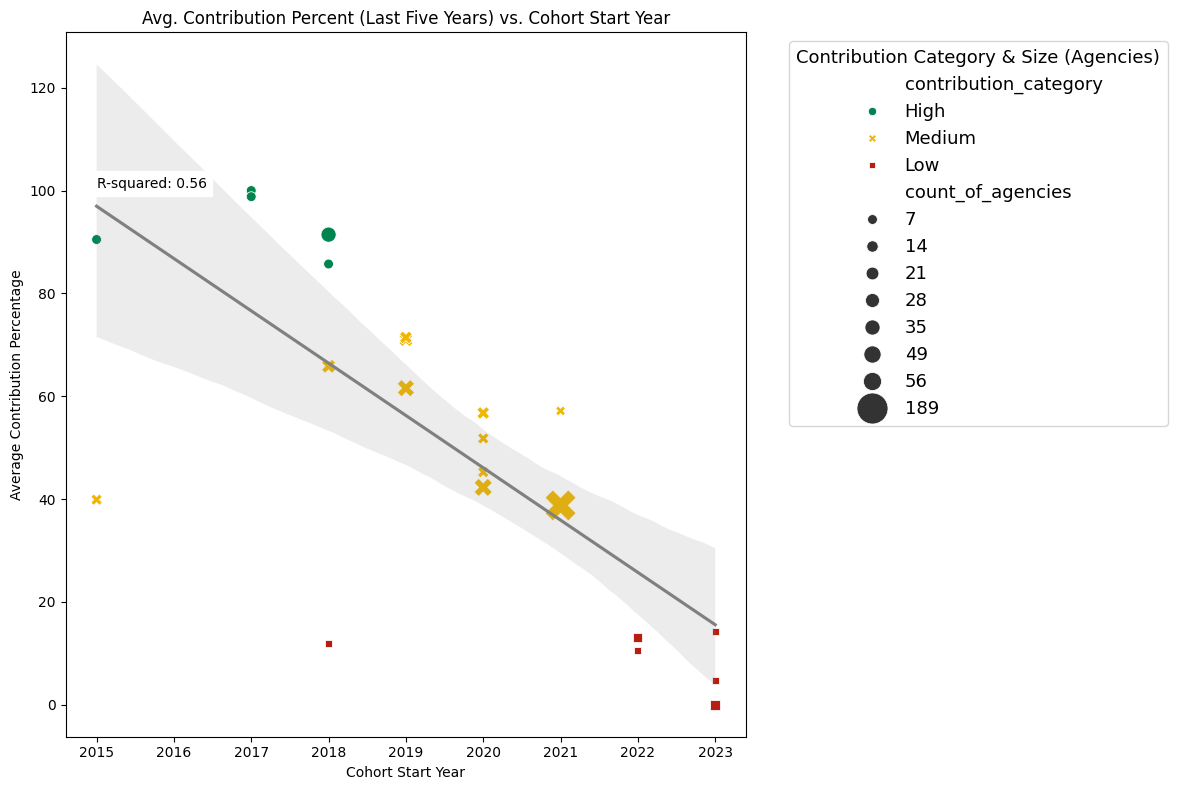

In [141]:
# Calculate the average contribution percentage for each cohort across all years
cohort_avg_contributions = avg_contribution_per_report_year_cohort.groupby('cohort')['avg_contribution_percentage'].mean().reset_index()

# Define a function to categorize each cohort based on the defined thresholds
def categorize_contribution(avg_percentage):
    if avg_percentage > 75:
        return 'High'
    elif avg_percentage > 25:
        return 'Medium'
    else:
        return 'Low'

# Apply the categorization
cohort_avg_contributions['contribution_category'] = cohort_avg_contributions['avg_contribution_percentage'].apply(categorize_contribution)

# Extract the start year from the cohort labels
cohort_avg_contributions['start_year'] = cohort_avg_contributions['cohort'].apply(lambda x: int(x[:4]))

# Merge the 'count_of_agencies' from 'agencies_per_cohort'
cohort_contributions_with_agencies = pd.merge(cohort_avg_contributions, agencies_per_cohort[['cohort', 'count_of_agencies']], on='cohort', how='left')

# Perform linear regression to find the R-squared value
regression_result = linregress(cohort_contributions_with_agencies['start_year'], cohort_contributions_with_agencies['avg_contribution_percentage'])
r_squared = regression_result.rvalue ** 2

# Specify colors for each contribution category
palette = {'High': '#008450',  # Green
           'Medium': '#EFB700',  # Yellow
           'Low': '#B81D13'}  # Red

# Visualize the relationship between start year and average contribution percentage with adjusted point sizes and colors
plt.figure(figsize=(12, 8))
sns.scatterplot(
        data=cohort_contributions_with_agencies, 
        x='start_year', 
        y='avg_contribution_percentage', 
        hue='contribution_category', 
        style='contribution_category', 
        size='count_of_agencies', 
        sizes=(50, 500), 
        palette=palette, 
        legend='full'
    )
sns.regplot(
        data=cohort_contributions_with_agencies, 
        x='start_year', 
        y='avg_contribution_percentage', 
        scatter=False, 
        color='gray'
    )

plt.title('Avg. Contribution Percent (Last Five Years) vs. Cohort Start Year')
plt.xlabel('Cohort Start Year')
plt.ylabel('Average Contribution Percentage')
plt.legend(
        title='Contribution Category & Size (Agencies)',
        title_fontsize='13', 
        bbox_to_anchor=(1.05, 1), 
        loc='upper left', 
        prop={'size': 13}
    )

# Add the R-squared value to the plot
plt.text(
        x=min(cohort_contributions_with_agencies['start_year']), 
        y=max(cohort_contributions_with_agencies['avg_contribution_percentage']), 
        s=f'R-squared: {r_squared:.2f}', 
        backgroundcolor='white', 
        ha='left', 
        va='bottom'
    )

plt.tight_layout()
plt.show()

In [140]:
cohort_avg_contributions.head()

,cohort,avg_contribution_percentage,contribution_category,start_year
0,2015Q1,90.477143,High,2015
1,2015Q3,39.880000,Medium,2015
2,2016Q4,100.000000,High,2016
3,2017Q2,100.000000,High,2017
4,2017Q4,98.810000,High,2017


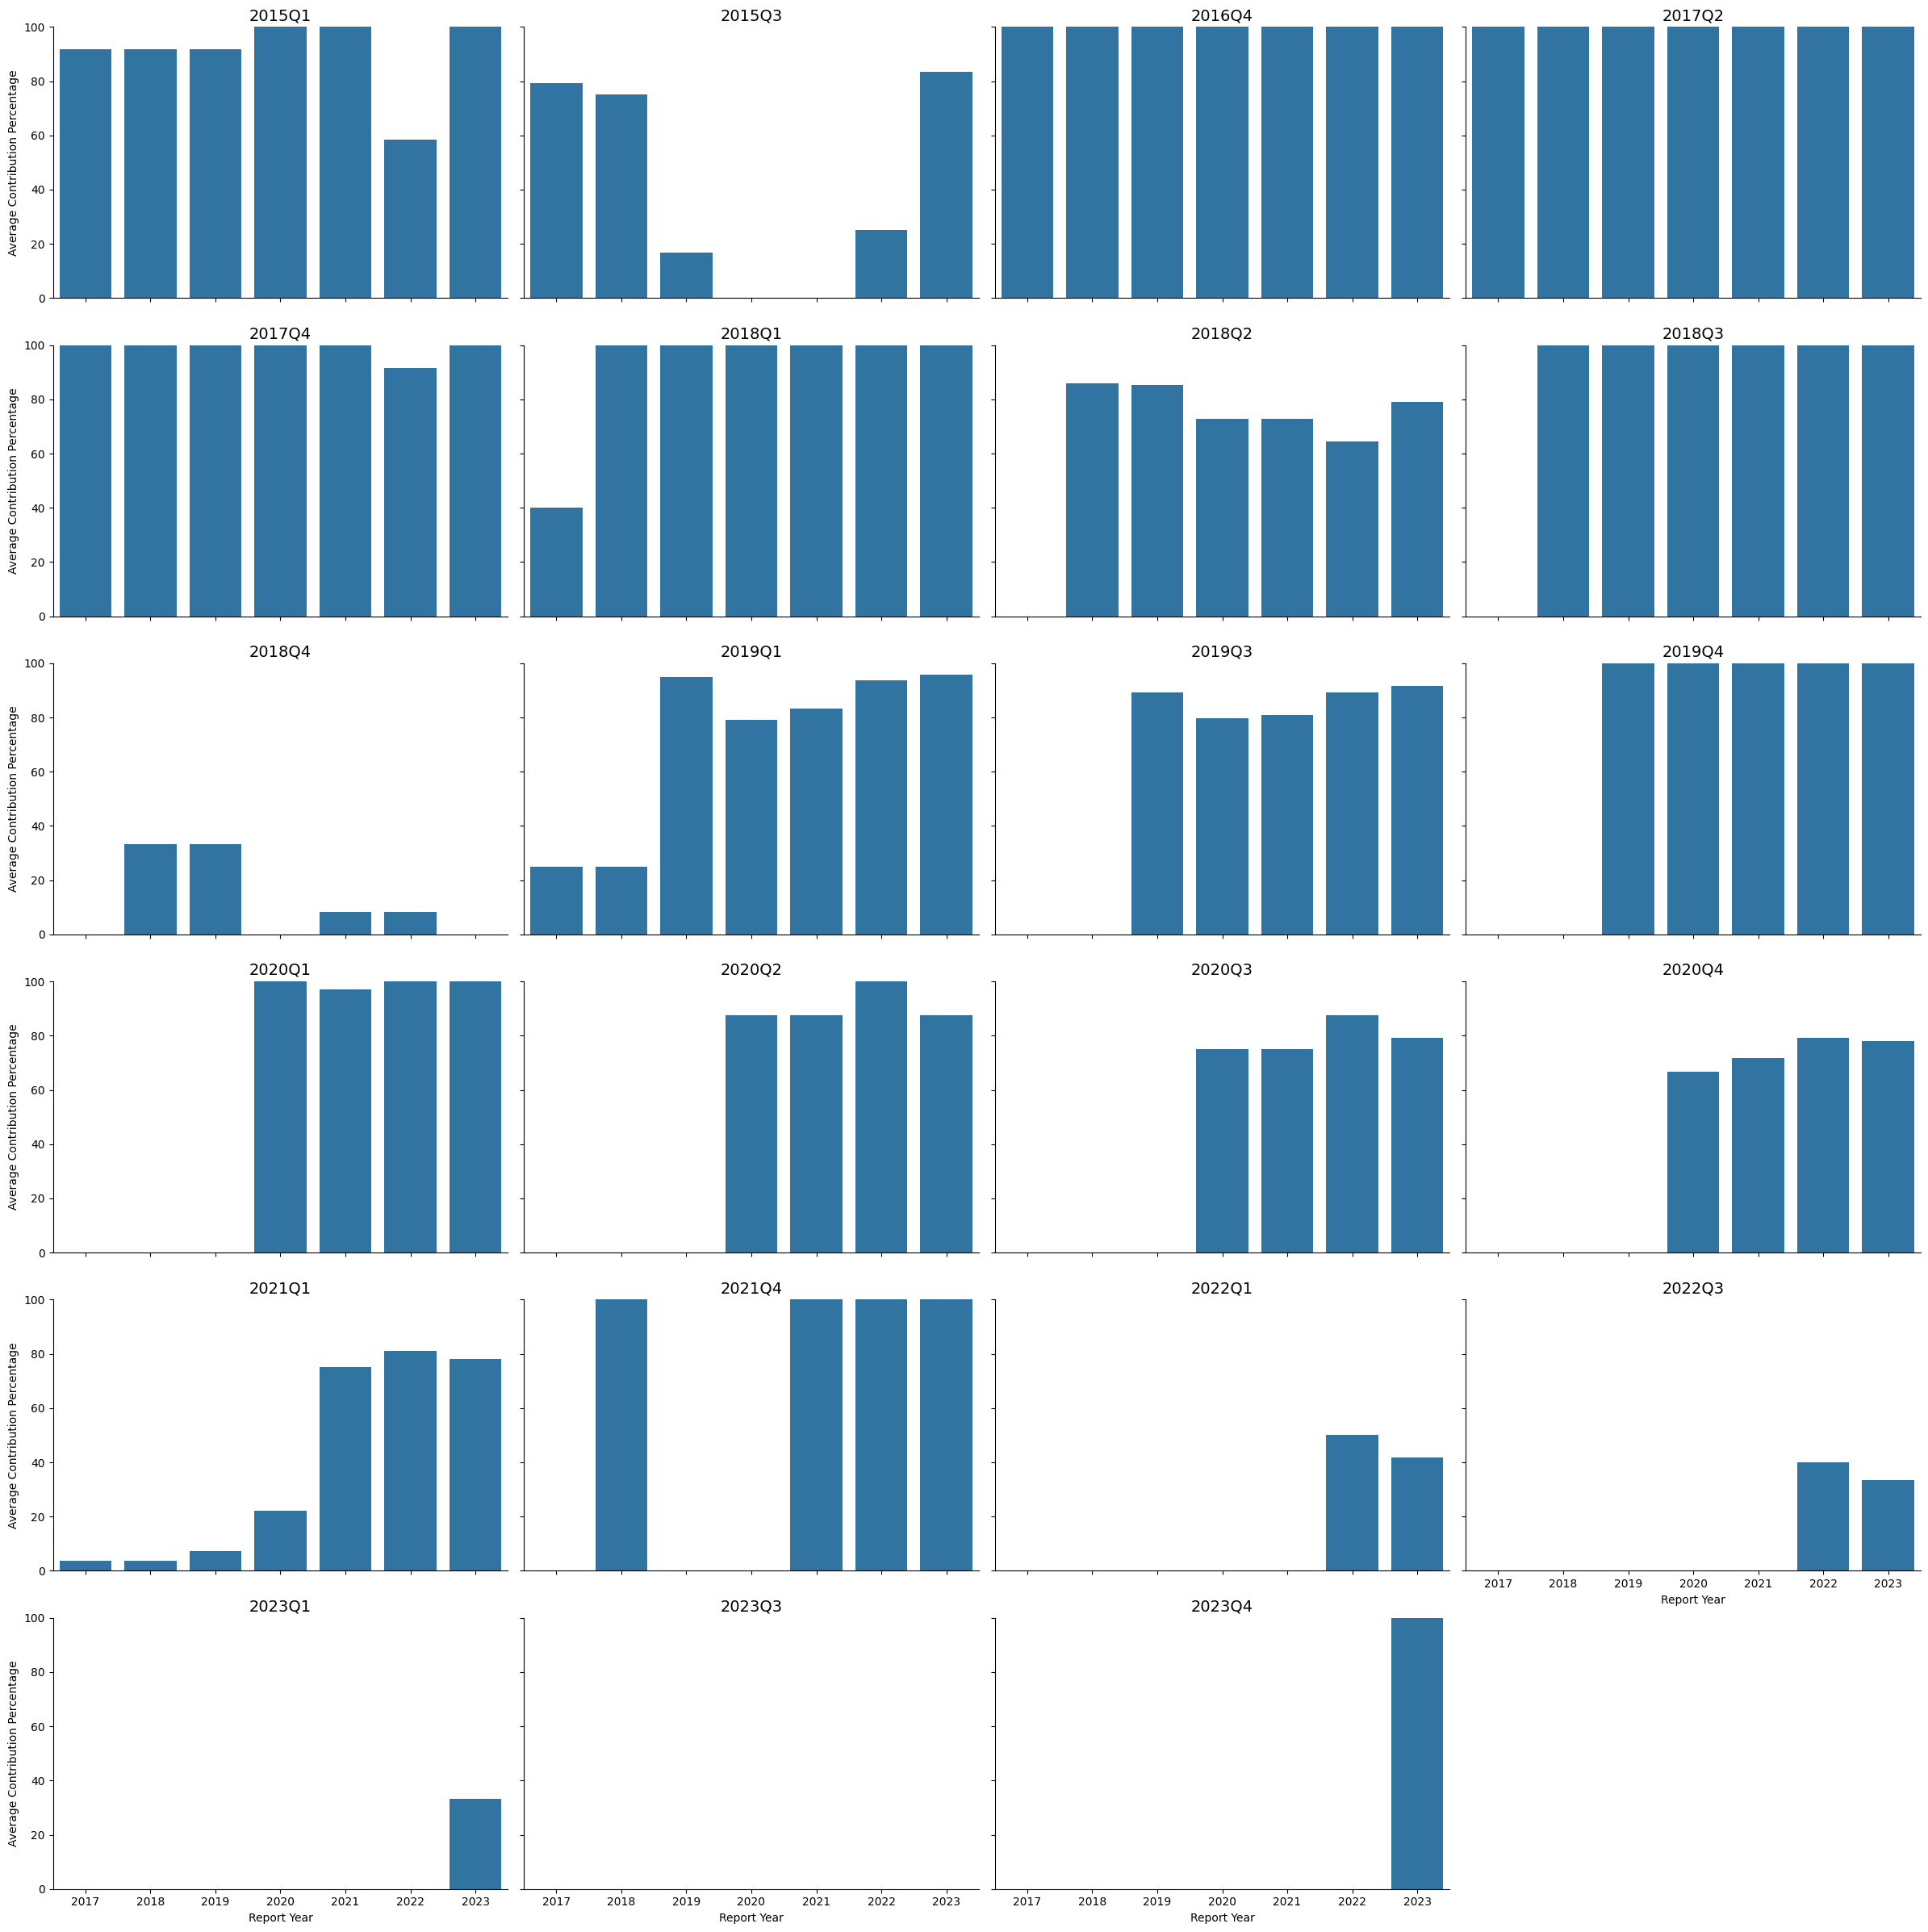

In [124]:
#this graph is pretty good, but it needs work in order for it to be more readable. 
# Create a FacetGrid, specifying the cohort as columns
g = sns.FacetGrid(avg_contribution_per_report_year_cohort, col="cohort", col_wrap=4, height=4, aspect=1.5)

# Map the data to the grid, using sns.barplot for bar charts. We use color to set a uniform color.
g = g.map(
        sns.barplot, 
        "report_year", 
        "avg_contribution_percentage", 
        order=sorted(avg_contribution_per_report_year_cohort['report_year'].unique())
    )

# Adjust titles for clarity
g = g.set_titles("{col_name}", size=14)

# Adjust the axis labels
g.set_axis_labels("Report Year", "Average Contribution Percentage")

# Set the y-axis limit to 0 to 100
g.set(ylim=(0, 100))

# Show the plot
plt.show()

In [125]:
# border_report.to_csv('texas_border_report_cleaned.csv', index=False)

In [126]:
# Think about corruptions within these police departments. Ex: Alamo PD has had problems. Maybe some sentiment analysis around this?

Things to do: 
1) ~~How many agencies are covered in the border report? How many agencies are there per county?~~
2) What does the distribution of NIBRS participation look like? How many agencies submit data for all 12 months?


Notes:
- National Incident-Based Reporting System (NIBRS) captures detailed data about the characteristics of criminal incidents, including:
    - a broad array of offenses
    - types and amount of property lost
    - demographic information about victims, offenders, and persons arrested
    - what type of weapon, if any, was used in the incident
- The NIBRS program was announced in 2016. The FBI transitioned to NIBRS-only data collection in 2021
- Summary Reporting System (SRS) was the standard before NIBRS
- The FBI leads the Uniform Crime Reporting Program (UCR). The program is voluntary, but Texas mandated participation in 2023

The name of my dataframe is 'border_report'. Using pandas, please create a new column called 'nibrs_status'. This column compares the year extracted from the 'nibrs_start_date' column to the year in the 'report_year' column. Here are the conditions and resulting values that the column should capture:
- if 'nibrs_start_date' < report_year, then 'nibrs_data'
- if 'nibrs_start_date' = report_year, then 'nibrs_transion'
- if 'nibrs_start_date' > report_year, then 'non_nibrs_data'

The date data in my .xlsx sheet is being displayed as 'MMM-YY', but if I reformat the data, I can see that the underlying data is 'MM-DD-YYYY'. Can I adjust the code to parse out the full date correctly?